
这段代码实现了一个基于多层感知机（MLP）的字符级语言模型，用于生成类似于输入名字列表的新名字。

主要功能和步骤如下：

1.  **数据加载与预处理**：
    *   从 `names.txt` 文件中读取名字列表。
    *   构建字符词汇表，并创建字符到整数 (`stoi`) 和整数到字符 (`itos`) 的映射。特殊字符 `.` 用于标记名字的开始和结束。
2.  **数据集构建**：
    *   定义 `block_size` (代码中为3)，表示使用前3个字符作为上下文来预测下一个字符。
    *   创建输入序列 `X`（上下文）和目标序列 `Y`（下一个字符的索引）。
    *   将数据集随机打乱，并划分为训练集（80%）、验证集（10%）和测试集（10%）。
3.  **模型定义 (MLP)**：
    *   **嵌入层 (C)**：将输入的字符索引映射为低维向量（嵌入向量，代码中维度为10）。
    *   **隐藏层**：将3个字符的嵌入向量拼接后，通过一个线性层 (`W1`, `b1`) 和 `tanh` 激活函数处理，得到隐藏层表示（代码中维度为200）。
    *   **输出层**：通过另一个线性层 (`W2`, `b2`) 将隐藏层表示映射为每个字符的得分（logits，维度为27，对应词汇表大小）。
4.  **训练**：
    *   初始化模型参数 (`C`, `W1`, `b1`, `W2`, `b2`) 并设置允许计算梯度。
    *   定义优化器（随机梯度下降）和学习率策略（前10万步为0.1，之后为0.01）。
    *   进行迭代训练（20万次）：
        *   随机抽取小批量数据。
        *   执行前向传播，计算模型的预测输出 (logits)。
        *   使用 `F.cross_entropy` 计算损失（包括了 Softmax 和负对数似然损失）。
        *   执行反向传播，计算梯度。
        *   更新模型参数。
        *   记录损失变化。
5.  **评估与可视化**：
    *   绘制训练过程中的损失曲线。
    *   计算模型在训练集和验证集上的最终损失。
    *   使用 `matplotlib` 可视化二维字符嵌入向量 (`C`)，观察字符之间的关系。
6.  **生成新名字**：
    *   使用训练好的模型进行采样：从起始上下文 `...` 开始，根据模型预测的下一个字符的概率分布进行采样，逐步生成新的字符，直到生成结束符 `.` 为止，从而生成新的名字。


In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [25]:
# read in all the words
words = open('D:/Nanogpt/Makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [26]:
# 统计单词数量
len(words)

32033

In [27]:
# build the vocabulary of characters and mappings to/from integers
# 构建字符词汇表和字符到整数的映射
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [28]:
# 构建数据集

block_size = 3 # 上下文长度：用3个字符预测下一个字符
X, Y = [], []  # 初始化 X 和 Y 为空列表
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # 滑动窗口更新上下文
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [29]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [30]:
# 定义构建数据集的函数
block_size = 3 # 上下文长度：用于预测下一个字符的字符数

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # 裁剪并追加

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 训练集
Xdev, Ydev = build_dataset(words[n1:n2]) # 验证集
Xte, Yte = build_dataset(words[n2:])  # 测试集


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
# 初始化嵌入矩阵
C = torch.randn((27, 2))

In [32]:
# 获取嵌入
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [33]:
# 初始化第一层权重和偏置
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [34]:
# 计算隐藏层激活值
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [35]:
# 查看隐藏层输出
h

tensor([[-0.8473, -0.9889,  0.4053,  ...,  0.9994,  0.9996, -0.9953],
        [-0.7531, -0.9900,  0.9548,  ...,  0.8845,  0.9677, -0.9571],
        [-0.9162, -0.9685,  0.5394,  ...,  0.0733,  0.9984, -0.1062],
        ...,
        [-0.9012,  0.4484, -0.2308,  ..., -0.6687,  0.8584,  0.5131],
        [-0.6986, -0.5704, -0.5720,  ..., -0.7409,  0.9955,  0.0811],
        [-0.6943, -0.1343, -0.4002,  ..., -0.9181,  0.5865, -0.5234]])

In [36]:
# 查看隐藏层形状
h.shape

torch.Size([228146, 100])

In [37]:
# 初始化第二层权重和偏置
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [38]:
# 计算输出 logits
logits = h @ W2 + b2

In [39]:
logits.shape

torch.Size([228146, 27])

In [40]:
# 计算指数
counts = logits.exp()

In [41]:
# 计算概率
prob = counts / counts.sum(1, keepdims=True)

In [42]:
prob.shape

torch.Size([228146, 27])

In [43]:
# 计算损失
batch_size = 32
ix = torch.randint(0, X.shape[0], (batch_size,))
loss = -prob[ix][torch.arange(batch_size), Y[ix]].log().mean()
loss

tensor(22.4992)

In [44]:
# ------------ now made respectable :) ---------------

In [45]:
# 优化后的代码
Xtr.shape, Ytr.shape # 查看训练集形状

(torch.Size([182625, 3]), torch.Size([182625]))

In [46]:
# 设置随机种子以确保可重复性
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [47]:

# 计算总参数数量
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [48]:
# 启用梯度计算
for p in parameters:
  p.requires_grad = True

In [49]:

# 定义学习率范围
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [50]:

# 存储学习率、损失和步数
lri = []
lossi = []
stepi = []

In [51]:
# 训练循环
for i in range(200000):
  
  # minibatch construct 构建小批量
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass 前向传播
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass 反向传播
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update 更新参数
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats 跟踪统计信息
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

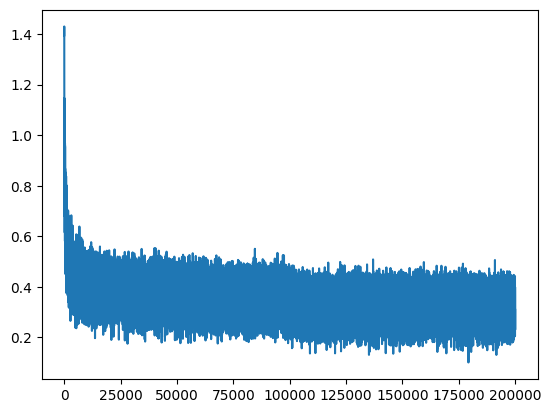

In [52]:
# 绘制损失曲线
plt.plot(stepi, lossi)

In [53]:
# 计算训练集损失
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1234, grad_fn=<NllLossBackward0>)

In [54]:
# 计算验证集损失
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1616, grad_fn=<NllLossBackward0>)

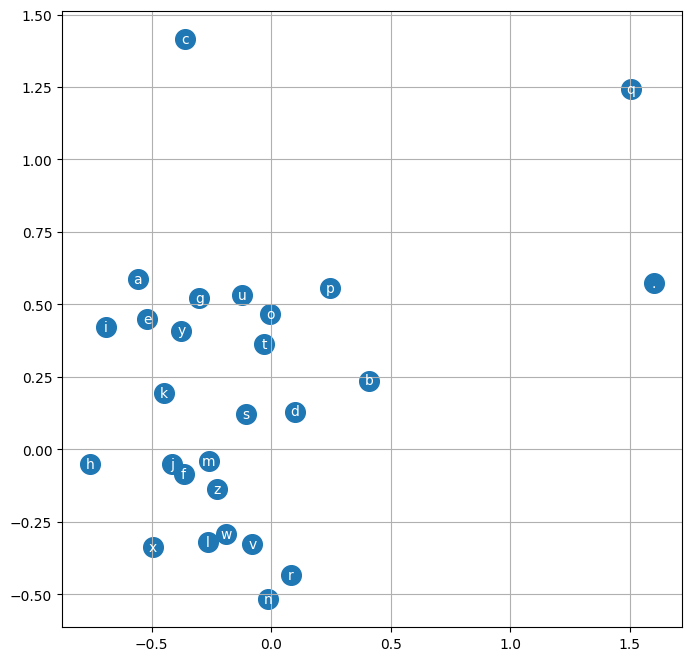

In [55]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# 可视化嵌入矩阵的第0和第1维
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [56]:
# training split, dev/validation split, test split 训练集、验证集、测试集划分比例
# 80%, 10%, 10%

In [57]:
# 查看上下文嵌入形状
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:


# sample from the model  从模型中采样
# 由 C, W1, b1, W2, b2 参数定义
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
keel.
nihayla.
rethan.
endraegan.
ched.
elin.
shi.
jen.
edelisson.
artelynn.
hotalin.
shubergiagriel.
kinto.
jenslen.
prifo.
breyce.
ryyah.
fael.
